<a href="https://colab.research.google.com/github/mrchhaya/NoTestNoProblem/blob/master/MachineLearning/CovidLung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
# number of folds for k-fold cross validation
k = 8

# load file paths
covidPositivePaths = os.listdir('COVID-POSITIVE')
covidNegativePaths = os.listdir('COVID-NEGATIVE')


In [2]:
# Start Functions -------------

# Find classification from file name
def getClass(path):
    if path in covidPositivePaths:
        return 0
    else:
        return 1

# get image byte array from path
def loadImage(path, ts=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=ts)
    return tf.keras.preprocessing.image.img_to_array(img)

# Create tensorflow model
def makeModel(transferLearning = False, modelOptimizer='adam', ts=(256, 256)):
    if transferLearning:
        pretrained_model = InceptionV3(
        input_shape = (*ts, 3),
        include_top = False,
        weights = 'imagenet')

        for layer in pretrained_model.layers:
            layer.trainable = False

        last_layer = pretrained_model.get_layer('mixed7')
        #last_layer = pretrained_model.layers[145]
        last_output = last_layer.output
        x = layers.Flatten()(last_output)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(1, activation = 'sigmoid')(x)

        model = tf.keras.Model(pretrained_model.input, x)
    else:
        # define Convolutional NN
        model = tf.keras.Sequential([tf.keras.layers.Conv2D(16, (3,3), input_shape = (256, 256, 3), activation='relu'),
                                 tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                 tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                 tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                 tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                 tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(256, activation = 'relu'),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tf.keras.layers.Dropout(.2),
                                 tf.keras.layers.Dense(1, activation = 'sigmoid')])
        # compile model
    model.compile(optimizer = modelOptimizer, loss='binary_crossentropy', metrics=['acc'])
    return model

# End Functions --------------

In [3]:
# merge and shuffle paths
mergedPaths = covidNegativePaths + covidPositivePaths
random.shuffle(mergedPaths)


# split mergedPaths in folds
base_ammount = len(mergedPaths) // k
folds = []
for foldIndex in range(k):
    if foldIndex != (k-1):
        folds.append(mergedPaths[foldIndex*base_ammount:(foldIndex+1)*base_ammount + 1])
    else:
        folds.append(mergedPaths[foldIndex*base_ammount:])

In [4]:
# create k models using k-1 folds for training and k folds for validation
models = []
foldLabels = []
for fold in folds:
    models.append(makeModel(transferLearning = False))
    foldLabel = []
    for item in fold:
        foldLabel.append(getClass(item))  
    foldLabels.append(foldLabel)

In [5]:
# train all of the models with their respective folds
foldHistory = []
for i in range(k):
    trainingData, trainingLabels, valData, valLabels = [], [], [], []
    for j in range(k):
        if j!= i:
            trainingData += list(map(lambda x: loadImage('MERGED_FILES/' + x), folds[j]))
            trainingLabels += foldLabels[j]
        else:
            valData += list(map(lambda x: loadImage('MERGED_FILES/' + x), folds[j]))
            valLabels += foldLabels[j]
    print('Training Fold {curr}/{total}'.format(curr = i+1, total=k))

    trainingData = np.array(trainingData)
    trainingLabels = np.array(trainingLabels)
    valData = np.array(valData)
    valLabels = np.array(valLabels)

    history = models[i].fit(trainingData, trainingLabels, epochs=30, validation_data=(valData, valLabels))
    foldHistory.append(history)

Training Fold 1/8
Epoch 1/30
21/21 [==============================] - 1s 50ms/step - loss: 85.8869 - acc: 0.5372 - val_loss: 0.6053 - val_acc: 0.6809
Epoch 2/30
21/21 [==============================] - 1s 24ms/step - loss: 0.5334 - acc: 0.7344 - val_loss: 0.5052 - val_acc: 0.7660
Epoch 3/30
21/21 [==============================] - 1s 25ms/step - loss: 0.3508 - acc: 0.8392 - val_loss: 0.5722 - val_acc: 0.7447
Epoch 4/30
21/21 [==============================] - 1s 25ms/step - loss: 0.2224 - acc: 0.9165 - val_loss: 0.7560 - val_acc: 0.7234
Epoch 5/30
21/21 [==============================] - 1s 26ms/step - loss: 0.1348 - acc: 0.9454 - val_loss: 1.0105 - val_acc: 0.7234
Epoch 6/30
21/21 [==============================] - 1s 25ms/step - loss: 0.0751 - acc: 0.9697 - val_loss: 1.0755 - val_acc: 0.7553
Epoch 7/30
21/21 [==============================] - 0s 24ms/step - loss: 0.0454 - acc: 0.9848 - val_loss: 1.8232 - val_acc: 0.6809
Epoch 8/30
21/21 [==============================] - 1s 25ms/step

In [6]:
for i in range(k):
    models[i].save('exportedModels/modelv2Fold{}.h5'.format(i))

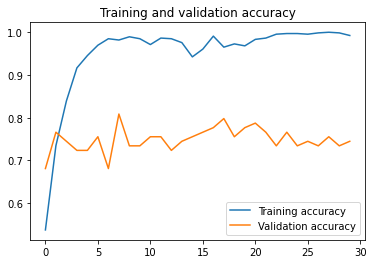

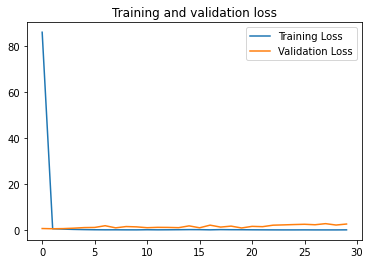

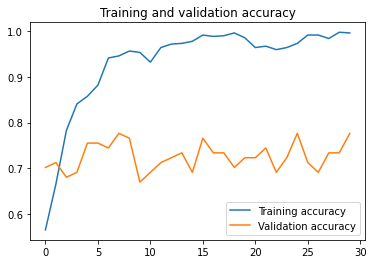

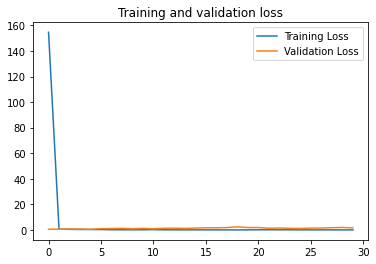

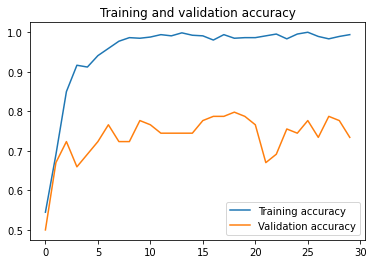

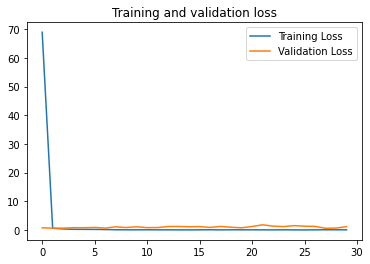

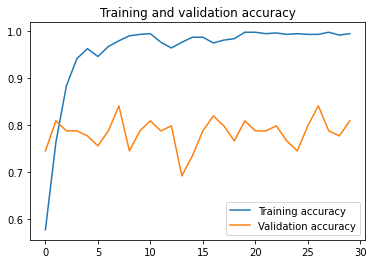

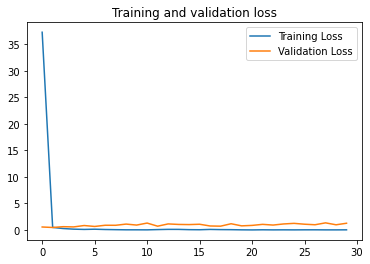

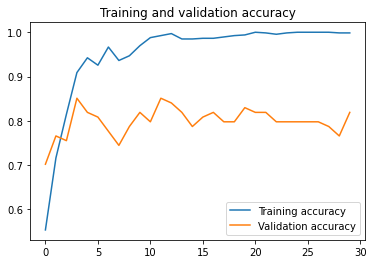

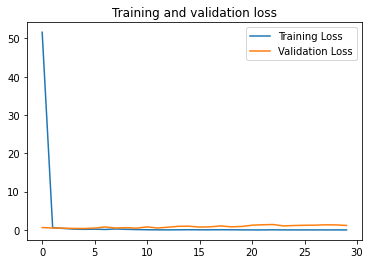

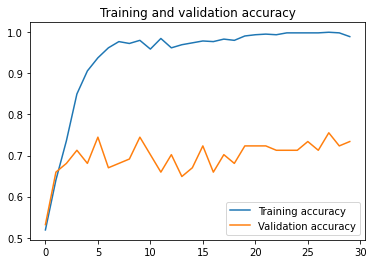

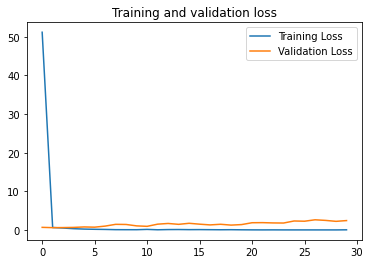

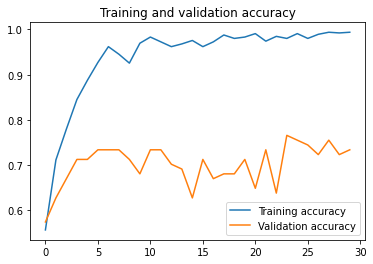

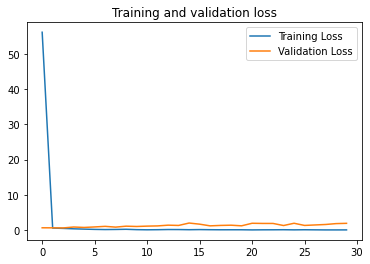

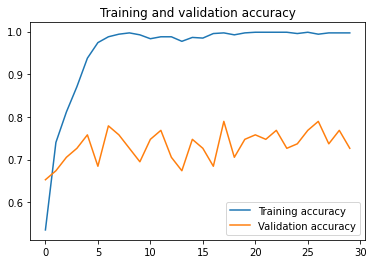

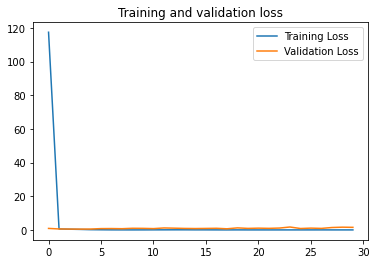

In [7]:
import matplotlib.pyplot as plt

for history in foldHistory:

    #load metrics from history object
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()